In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_raw = pd.read_csv(os.path.join('data','Data for Study Case - Business Analyst.csv'))

## Data Understanding

In [3]:
data_raw.head()

,Date,Time,Outlet_Name,Outlet_Location,Total_Price
0,23/02/2023,23:34,Outlet A,NaN,"Rp 1,897,000"
1,23/02/2023,23:34,Outlet A,NaN,"Rp 1,897,000"
2,23/02/2023,23:34,Outlet A,NaN,"Rp 1,897,000"
3,23/02/2023,23:34,Outlet A,NaN,"Rp 1,897,000"
4,23/02/2023,21:42,Outlet C,Location A,"Rp 35,000"


In [4]:
data_raw.shape

(16329, 5)

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16329 entries, 0 to 16328
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             16329 non-null  object
 1   Time             16329 non-null  object
 2   Outlet_Name      16329 non-null  object
 3   Outlet_Location  1813 non-null   object
 4   Total_Price      16276 non-null  object
dtypes: object(5)
memory usage: 638.0+ KB


In [111]:
data_raw.columns

Index(['Outlet_Name', 'Outlet_Location', 'Total_Price', 'datetime'], dtype='object')

In [6]:
sum_missing = data_raw.isna().sum()
percent_missing = round(data_raw.isnull().sum() *100 / len(data_raw),2)
missing_value_df = pd.DataFrame({'feature_name': data_raw.columns,
                                 'sum_missing': sum_missing,
                                 'percent_missing': percent_missing}).reset_index(drop=True).sort_values(by='sum_missing', ascending=False)
missing_value_df.head(9)

,feature_name,sum_missing,percent_missing
3,Outlet_Location,14516,88.90
4,Total_Price,53,0.32
0,Date,0,0.00
1,Time,0,0.00
2,Outlet_Name,0,0.00


Note:
- Missing values on Total Price means there are 53 transactions that were not recorded properly

In [7]:
data_outlet = data_raw[(data_raw['Outlet_Location'].notnull())]
data_outlet_a = data_raw[data_raw['Outlet_Location'] == 'Location A']
data_outlet_b = data_raw[data_raw['Outlet_Location'] == 'Location B']

print('Outlet Total:',data_raw['Outlet_Name'].nunique())
print('Location Total:',data_raw['Outlet_Location'].nunique())
print('Total Outlet in Location A:', data_outlet_a['Outlet_Name'].nunique(), data_outlet_a['Outlet_Name'].unique())
print('Total Outlet in Location B:', data_outlet_b['Outlet_Name'].nunique(), data_outlet_b['Outlet_Name'].unique())

Outlet Total: 76
Location Total: 2
Total Outlet in Location A: 3 ['Outlet C' 'Outlet D' 'Outlet E']
Total Outlet in Location B: 3 ['Outlet AA' 'Outlet BC' 'Outlet BW']


If we assume that Outlets with no location data are in different locations each, then it can be assumed that there are 76 Outlets in `70 different locations`

## Data Cleaning and Manipulation

### Drop missing values in Total_Price

In [8]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16329 entries, 0 to 16328
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             16329 non-null  object
 1   Time             16329 non-null  object
 2   Outlet_Name      16329 non-null  object
 3   Outlet_Location  1813 non-null   object
 4   Total_Price      16276 non-null  object
dtypes: object(5)
memory usage: 638.0+ KB


In [9]:
data_raw.dropna(subset=['Total_Price'], inplace=True)

### Changing Total_Price Data type

In [10]:
# Remove currency symbol and commas from 'Total_Price' column
data_raw['Total_Price'] = data_raw['Total_Price'].str.replace('Rp', '').str.replace(',', '')

# Convert 'Total_Price' column to numeric
data_raw['Total_Price'] = pd.to_numeric(data_raw['Total_Price'], errors='coerce')

### Merging Date Time column

In [11]:
# Merging the 'date' and 'time' columns into a new 'datetime' column
data_raw['datetime'] = pd.to_datetime(data_raw['Date'] + ' ' + data_raw['Time'], format='%d/%m/%Y %H:%M')
data_raw.drop(['Date', 'Time'], axis=1, inplace=True)

In [12]:
data = data_raw.copy()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16276 entries, 0 to 16328
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Outlet_Name      16276 non-null  object        
 1   Outlet_Location  1810 non-null   object        
 2   Total_Price      16276 non-null  int64         
 3   datetime         16276 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 635.8+ KB


## Analysis and Visualization

In [14]:
import matplotlib.ticker as ticker

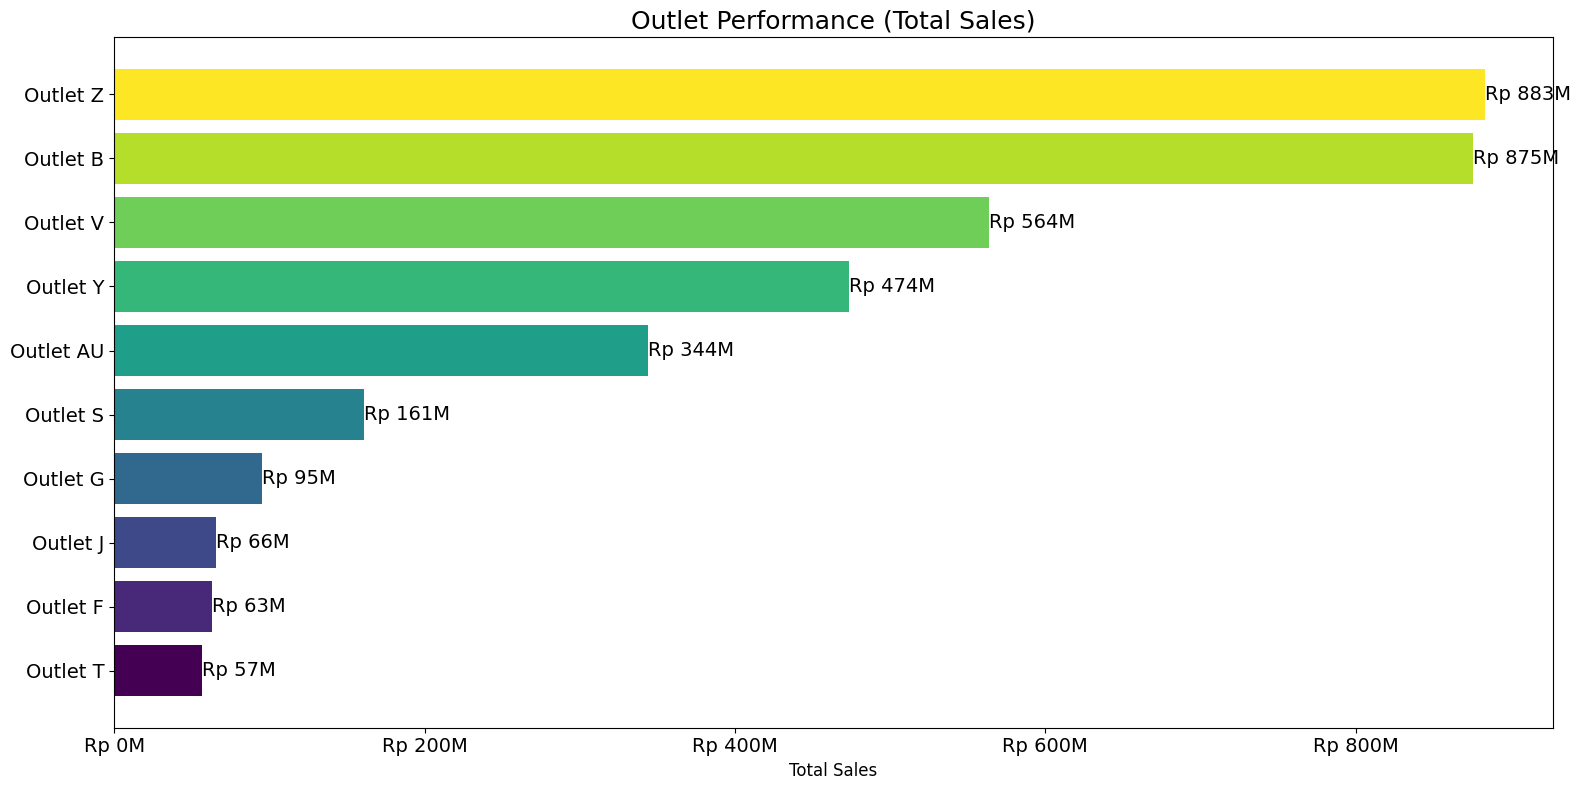

In [79]:
# Calculate the total sales per outlet
outlet_sales = data.groupby('Outlet_Name')['Total_Price'].sum().sort_values(ascending=False)

#Top 10 Outlets
top_10_outlets = outlet_sales.head(10)

# Generate a sequential colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_outlets)))

# Visualize Outlet Performance
plt.figure(figsize=(16, 8))
top_10_outlets = top_10_outlets.sort_values(ascending=True)  # Sort in ascending order for horizontal bar chart
plt.barh(top_10_outlets.index, top_10_outlets.values, color=colors)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('')
plt.title('Outlet Performance (Total Sales)', fontsize=18)

# Add data label
for i, v in enumerate(top_10_outlets):
    label = f"Rp {v/1e6:.0f}M"  # Convert value to millions and format the label
    plt.text(v, i, label, color='black', va='center', fontsize=14)

# Sets the formatter for the x-axis to display numbers in the millions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x/1e6:.0f}M'))

# Magnify the font on the x-axis and y-axis
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

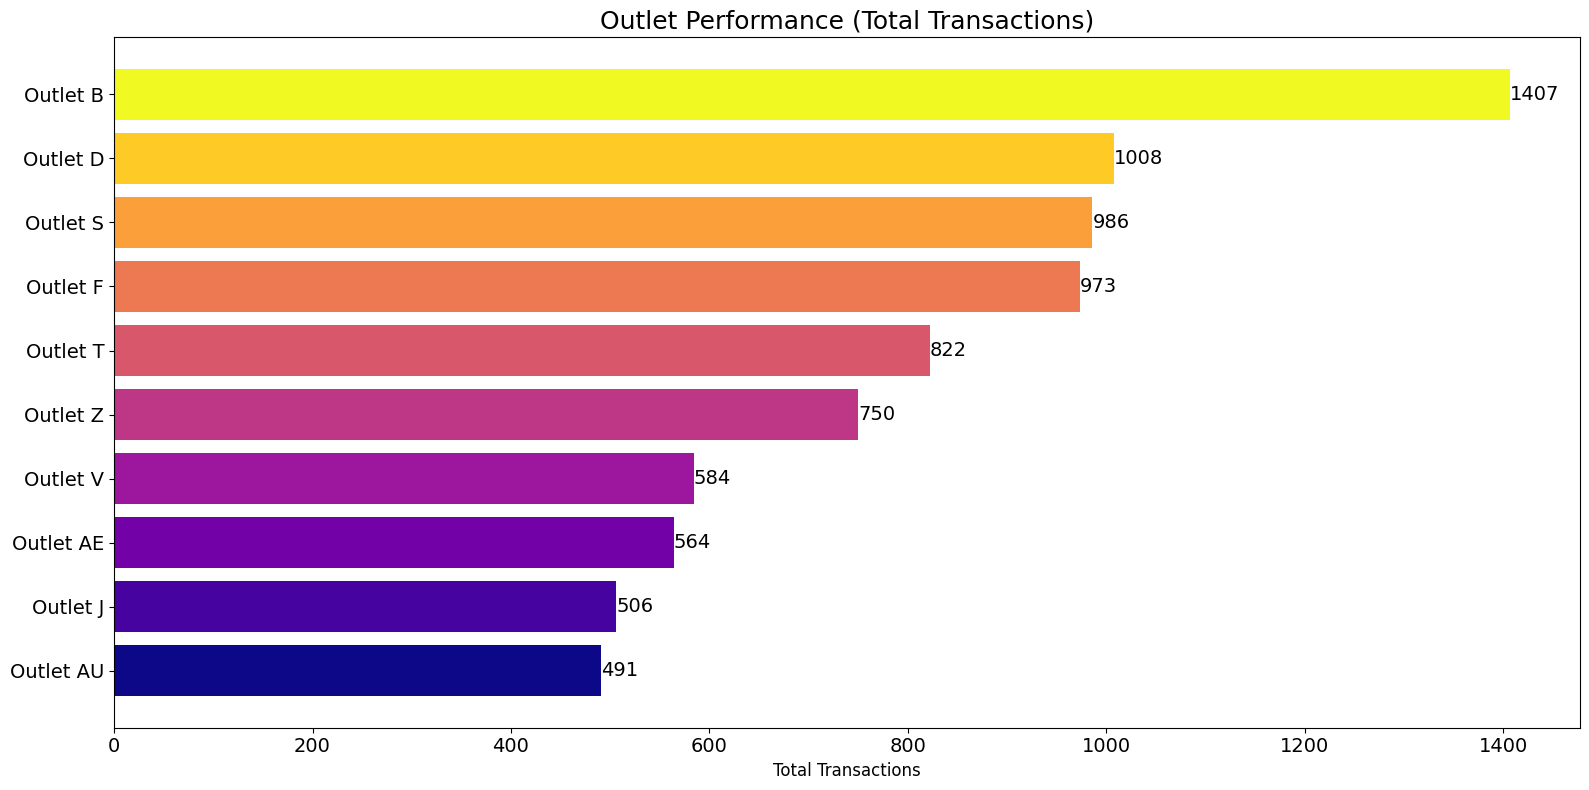

In [16]:
# Calculate the total sales per outlet
outlet_transc = data.groupby('Outlet_Name')['Total_Price'].count().sort_values(ascending=False)

# Top 10 Outlets
top_10_outlets = outlet_transc.head(10)

# Generate a different sequential colormap
colors = plt.cm.plasma(np.linspace(0, 1, len(top_10_outlets)))

# Visualize Outlet Performance
plt.figure(figsize=(16, 8))
top_10_outlets = top_10_outlets.sort_values(ascending=True)  # Sort in ascending order for horizontal bar chart
plt.barh(top_10_outlets.index, top_10_outlets.values, color=colors)
plt.xlabel('Total Transactions', fontsize=12)
plt.ylabel('')
plt.title('Outlet Performance (Total Transactions)', fontsize=18)

# Add data label
for i, v in enumerate(top_10_outlets):
    label = f"{v}"  # Display the total transaction count
    plt.text(v, i, label, color='black', va='center', fontsize=14)

# Magnify the font on the x-axis and y-axis
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

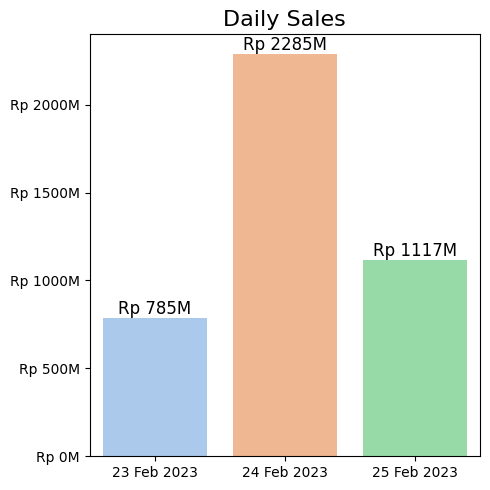

In [96]:
# Retrieving the 'datetime' and 'Total_Price' columns
sales_by_day = data[['datetime', 'Total_Price']].copy()

# Changed the 'datetime' column to a datetime data type
sales_by_day['datetime'] = pd.to_datetime(sales_by_day['datetime'])

# Calculate total sales per day
sales_by_day['Day'] = sales_by_day['datetime'].dt.date
daily_sales = sales_by_day.groupby('Day')['Total_Price'].sum()

# Sales analysis plot by day
plt.figure(figsize=(5, 5))

# Color Palette
color_palette = sns.color_palette("pastel")

# Plot bar
sns.barplot(x=daily_sales.index, y=daily_sales.values, palette=color_palette)

# Specifies the label format for each bar
label_format = 'Rp {:.0f}M'

# Add a label for each bar
for i, v in enumerate(daily_sales.values):
    label = label_format.format(v/1e6)
    plt.text(i, v, label, ha='center', va='bottom', color='black', fontsize=12)

# Displays labels in "Rp ...M"
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x/1e6:.0f}M'))

# Change the x-axis labels
plt.xticks(range(len(daily_sales.index)), [pd.to_datetime(date).strftime("%d %b %Y") for date in daily_sales.index], rotation=0)

plt.xlabel('')
plt.ylabel('')
plt.title('Daily Sales', fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


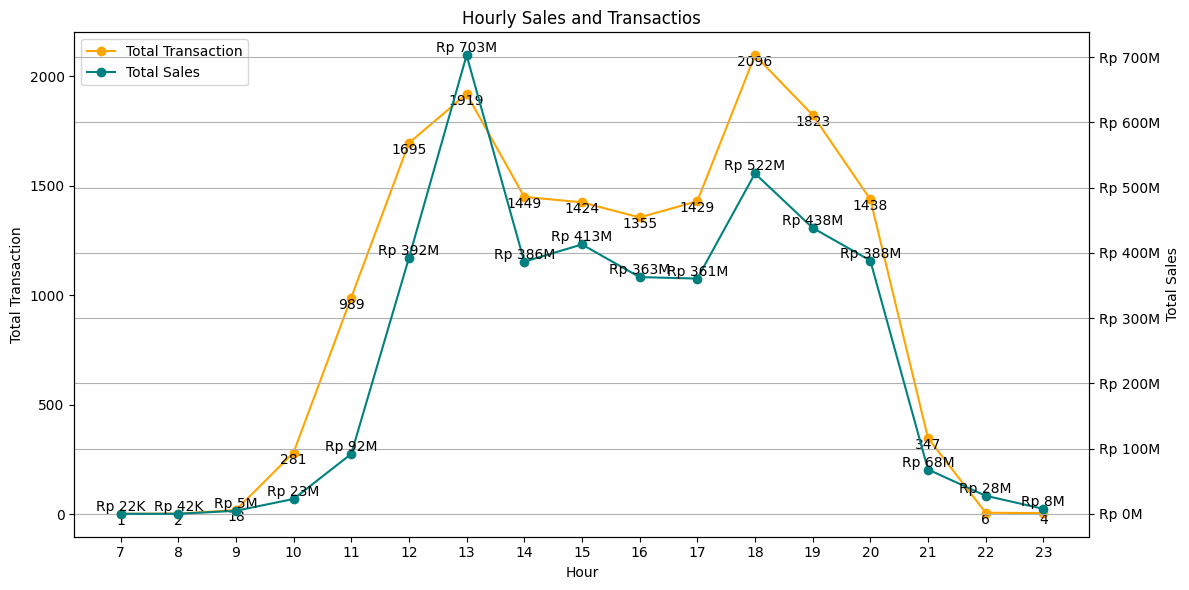

In [115]:
# Retrieving the 'datetime' and 'Total_Price' columns
sales_by_hour = data[['datetime', 'Total_Price']].copy()

# Changed the 'datetime' column to a datetime data type
sales_by_hour['datetime'] = pd.to_datetime(sales_by_hour['datetime'])

# Calculate total hourly sales
sales_by_hour['Hour'] = sales_by_hour['datetime'].dt.hour
hourly_transactions = sales_by_hour.groupby('Hour')['Total_Price'].count()
hourly_sales = sales_by_hour.groupby('Hour')['Total_Price'].sum()

# Hourly sales analysis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Line plot for total transaction
ax1.plot(hourly_transactions.index, hourly_transactions.values, marker='o', color='orange', label='Total Transaction')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Total Transaction')

# Create a second y-axis for total sales
ax2 = ax1.twinx()
# Line plot for total sales
ax2.plot(hourly_sales.index, hourly_sales.values, marker='o', color='teal', label='Total Sales')
ax2.set_ylabel('Total Sales')

# Set a label on each total transaction data point
for x, y in zip(hourly_transactions.index, hourly_transactions.values):
    label = f'{y}'
    ax1.text(x, y, label, ha='center', va='top')

# Set a label on each total transaction data point
for x, y in zip(hourly_sales.index, hourly_sales.values):
    if y < 1e6:
        label = f'Rp {y/1e3:.0f}K'
    else:
        label = f'Rp {y/1e6:.0f}M'
    ax2.text(x, y, label, ha='center', va='bottom')

# Menampilkan legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Hourly Sales and Transactios')
plt.xticks(range(7, 24))  # Menghilangkan poin 1-6 pada sumbu x
plt.grid(True)

# Displays labels in "Rp ...M"
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x/1e6:.0f}M'))

plt.tight_layout()
plt.show()

In [43]:
# Menghitung rata-rata jumlah transaksi harian dan rata-rata penjualan harian per outlet
daily_transactions = data.groupby(['Outlet_Name', data['datetime'].dt.date])['Total_Price'].count().mean(level=0)
daily_sales = data.groupby(['Outlet_Name', data['datetime'].dt.date])['Total_Price'].sum().mean(level=0)

# Membuat dataframe untuk tabel
table_data = pd.DataFrame({'Outlet': daily_transactions.index,
                           'Rata-rata Transaksi Harian': daily_transactions.values.round().astype(int),
                           'Rata-rata Penjualan Harian': daily_sales.values.round().astype(int)})

# Mengurutkan berdasarkan Rata-rata Penjualan Harian terbesar
table_data = table_data.sort_values(by='Rata-rata Penjualan Harian', ascending=False)

# Menampilkan tabel
pd.set_option('display.max_rows', None)  # Menampilkan seluruh baris
table_data

,Outlet,Rata-rata Transaksi Harian,Rata-rata Penjualan Harian
75,Outlet Z,250,294328700
27,Outlet B,469,291827200
71,Outlet V,195,187942685
74,Outlet Y,114,157860277
21,Outlet AU,164,114674396
68,Outlet S,329,53661083
56,Outlet G,153,31690265
59,Outlet J,169,21965667
55,Outlet F,324,21060000
69,Outlet T,274,18879000


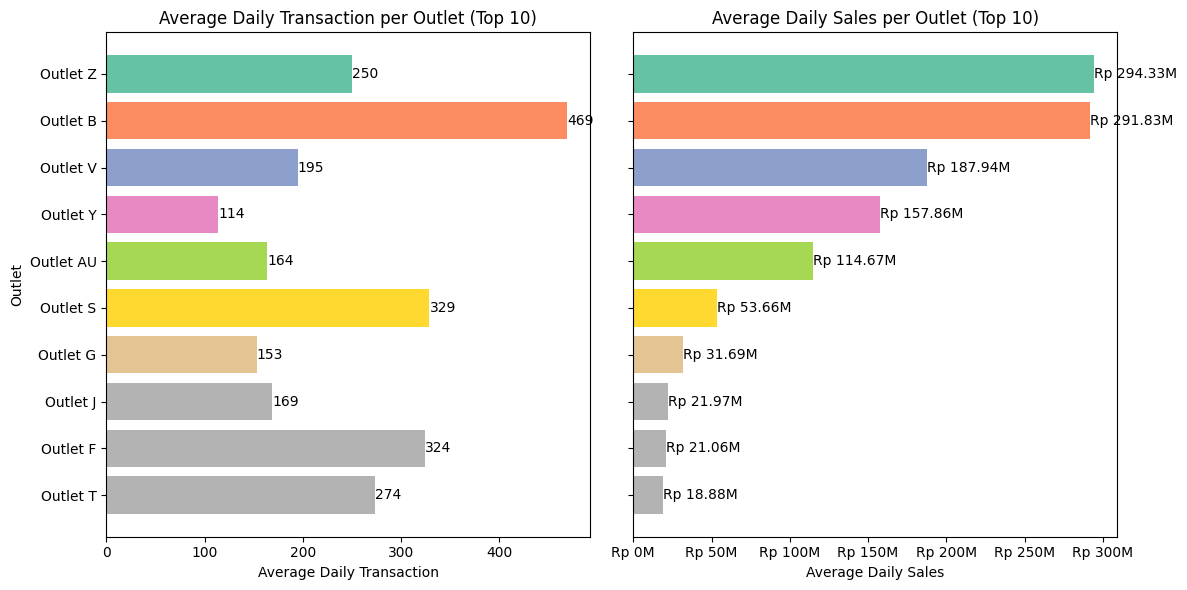

In [109]:
# Prepare data for visualization
top_10_outlets = table_data.nlargest(10, 'Rata-rata Penjualan Harian').sort_values('Rata-rata Penjualan Harian', ascending=False)
outlets = top_10_outlets['Outlet']
avg_transactions = top_10_outlets['Rata-rata Transaksi Harian']
avg_sales = top_10_outlets['Rata-rata Penjualan Harian']

# Color Scheme
colors = plt.cm.Set2(range(len(outlets)))

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Average Daily Transaction Plot
ax1.barh(outlets, avg_transactions, color=colors)
ax1.set_xlabel('Average Daily Transaction')
ax1.set_ylabel('Outlet')
ax1.set_title('Average Daily Transaction per Outlet (Top 10)')
ax1.invert_yaxis()

# Average Daily Sales Plot
ax2.barh(outlets, avg_sales, color=colors)
ax2.set_xlabel('Average Daily Sales')
ax2.set_title('Average Daily Sales per Outlet (Top 10)')

# Displays the Average Daily Sales label in "Rp ...B" format
for i, v in enumerate(avg_sales):
    label = f'Rp {v/1e6:.2f}M'
    ax2.text(v, i, label, va='center')

# Displays the label Average Daily Transactions
for i, v in enumerate(avg_transactions):
    label = str(v)
    ax1.text(v, i, label, va='center')
    
# Invert the y-axis in reverse
plt.gca().invert_yaxis()
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x/1e6:.0f}M'))

# Omit the y-axis labels on the right plot
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()

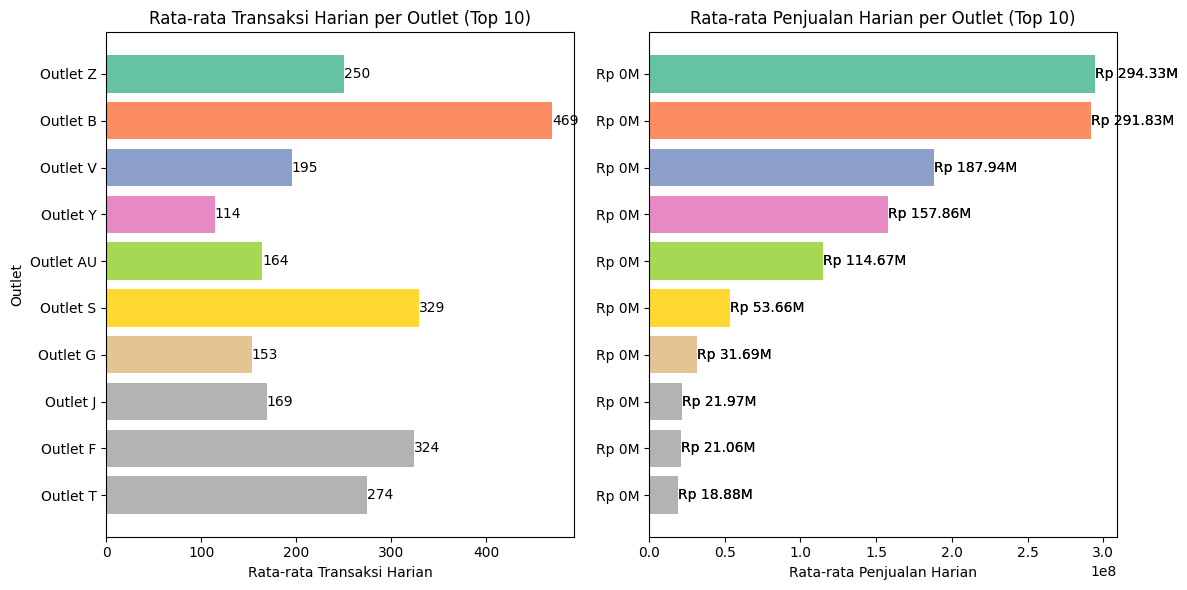

In [105]:
# Mengambil 10 outlet teratas dan mengurutkannya dari yang terbesar
top_10_outlets = table_data.nlargest(10, 'Rata-rata Penjualan Harian').sort_values('Rata-rata Penjualan Harian', ascending=False)

# Menyiapkan data untuk visualisasi
outlets = top_10_outlets['Outlet']
avg_transactions = top_10_outlets['Rata-rata Transaksi Harian']
avg_sales = top_10_outlets['Rata-rata Penjualan Harian']

# Mengatur skema warna
colors = plt.cm.Set2(range(len(outlets)))

# Membuat subplot dengan 1 baris dan 2 kolom
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Rata-rata Transaksi Harian
ax1.barh(outlets, avg_transactions, color=colors)
ax1.set_xlabel('Rata-rata Transaksi Harian')
ax1.set_ylabel('Outlet')
ax1.set_title('Rata-rata Transaksi Harian per Outlet (Top 10)')
ax1.invert_yaxis()

# Plot Rata-rata Penjualan Harian
ax2.barh(outlets, avg_sales, color=colors)
ax2.set_xlabel('Rata-rata Penjualan Harian')
ax2.set_title('Rata-rata Penjualan Harian per Outlet (Top 10)')
ax2.invert_yaxis()

# Menampilkan label Rata-rata Penjualan Harian dalam format "Rp ...M"
for i, v in enumerate(avg_sales):
    label = f'Rp {v/1e6:.2f}M'
    ax2.text(v, i, label, va='center')

# Menghilangkan label sumbu y pada plot kanan
ax2.set_yticklabels([])

# Menampilkan label Rata-rata Penjualan Harian dalam format "Rp ...M"
for i, v in enumerate(avg_sales):
    label = f'Rp {v/1e6:.2f}M'
    ax2.text(v, i, label, va='center')

# Menampilkan label Rata-rata Transaksi Harian
for i, v in enumerate(avg_transactions):
    label = str(v)
    ax1.text(v, i, label, va='center')
    
# Menampilkan label dalam format "Rp ...M"
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'Rp {x/1e6:.0f}M'))

# Menampilkan plot
plt.tight_layout()
plt.show()